# Figure 2: OIB magnetic basement tied to ANTOSTRAT seismic basement 
This notebook produces figure 2 of Tankersley et al. 2022. The figure shows the Werner deconvolution solutions and resulting magnetic basement depths, compared to seismic basement depths, for OIB flight 403, segment 1, in the Ross Sea.

In [3]:
# import necessary python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import copy
import pygmt
import os
import scipy.interpolate 

In [4]:
# all file paths assume this notebook is in /RIS_basement_sediment/Figures
pwd = os.getcwd()
pwd

'C:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_basement_sediment\\Figures'

## Load data

In [5]:
# import geosoft .csv with Werner solutions for OIB line 403, 404, and ROSETTA lines
file_in = '..\data\input\RIS123_1Hz_intermediate_Werner_2021_500_to_50k.csv'
df0 = pd.read_csv(file_in, header=0,index_col=None,sep=',')

# put line numbers into float format (L200 -> 200)
if type(df0.Line[0]) == str:
    df0.Line = df0.Line.str[1:]
df0['Line'] = pd.to_numeric(df0['Line']) 

# make dike solution depths be relative to sea level
# was relative to upwards continued flight elevation (1000masl)
df0['Depth'] = df0.Z_Dikes+1000

# if solutions are shallower then bathymetry, set equal to bathymetry
df0.Depth = np.where(df0.Depth>df0.bedmap2_bed, df0.bedmap2_bed, df0.Depth)  

# copy df to retain magnetics data to use in plotting
df_mag=copy.deepcopy(df0)

# drop columns and NaNs for oib dataset
df0_oib=df0.drop(df0.columns.difference(['Line','Distance','x','y','ANTOSTRAT_basement',
                                         'bedmap2_bed','Susc','Window_Width','Depth']), axis=1)
df0_oib.dropna(how='any', subset=('Line','Distance','x','y','Susc','Window_Width','Depth'), inplace=True)

# drop columns and NaNs for rosetta dataset
df0_rs=df0.drop(df0.columns.difference(['Line','Distance','x','y','bedmap2_bed', 
                                        'Susc','Window_Width','Depth']), axis=1)
df0_rs.dropna(how='any', subset=('Line','Distance','x','y','Susc','Window_Width','Depth'), inplace=True)

## Apply filtering and binning process

In [6]:
Line_oib=403.1
oib_parameter_s=1
oib_parameter_w=10000
oib_parameter_b=36000
oib_parameter_c=6

# isolate an individual line
oib = df0_oib[df0_oib.Line==Line_oib].copy()
oib_mag = df_mag[df_mag.Line==Line_oib]

# make sure ANTOSTRAT column is filled
oib.ANTOSTRAT_basement.interpolate(method='linear', axis=0, inplace=True, limit_area='inside')

# retain oib dataframe before filtering is applied
oib_filt=copy.deepcopy(oib)

"""
filter solutions based on susceptibility and window width
add filtered solutions depths and distances to new columns
i.e. Distance_36k and Depth_36k for iterations where b=36km
"""
Distance_name = 'Distance_'+(str(int(oib_parameter_b/1000))+'k')
Depth_name ='Depth_'+(str(int(oib_parameter_b/1000))+'k')
oib_filt = pd.concat([oib_filt,pd.DataFrame(columns=[Distance_name, Depth_name])]) # add above columns to oib
oib_filt[Distance_name] = np.floor(oib_filt.Distance[(oib_filt.Susc > oib_parameter_s) & 
                                                     (oib_filt.Window_Width < oib_parameter_w)]/oib_parameter_b)*oib_parameter_b 
oib_filt[Depth_name] = oib_filt.Depth[(oib_filt.Susc > oib_parameter_s) & (oib_filt.Window_Width < oib_parameter_w)]

oib_filt.dropna(inplace=True) # remove rows with NaNs

# Set bin centers equal to 95% depth of solutions within bin
def quant(x):
    return x.quantile(0.95)
# new df with only binned points, with distances set to the center of the bins and depths set to 95% of all points within bins
oib_bin_centers = oib_filt.groupby([Distance_name], as_index=False).agg({Depth_name: quant})
oib_bin_centers['Distance'] = oib_bin_centers[Distance_name]+(oib_parameter_b/2)
oib_bin_centers['binned']=1 # keep track of binned points

# rename Depth_name column so oib_bin_centers can be merged
oib_filt.rename(columns={Depth_name:'Depth_filtered'}, inplace=True)

# add the binned solutions to oib_filt
oib_filt_with_centers = oib_filt.set_index(['Distance', Distance_name]).join(oib_bin_centers.set_index(['Distance', Distance_name]), how='outer')
oib_filt_with_centers.reset_index(inplace=True)
oib_filt_with_centers.sort_values(['Distance'], inplace=True)
#fill nan's in columns, except 'binned'
for col in oib_filt_with_centers.columns:
    if col == 'binned':
        pass
    else:
        oib_filt_with_centers[col].interpolate(method='linear', limit_direction='both', inplace=True)    

"""
retain only the bins which contain a minumum number (count) of points
"""
# number of filtered points within each bin
oib_filt_with_centers['counts'] = oib_filt_with_centers.groupby([Distance_name])['Depth_filtered'].transform('count')
oib_bin_centers=oib_filt_with_centers[oib_filt_with_centers.binned.notna()]
oib_bin_centers=oib_bin_centers[oib_bin_centers.counts>oib_parameter_c]

"""
Compare OIB basement results with ANTOSTRAT basement results
"""
# interpolate line between binned points for comparison with ANTOSTRAT
x1 = min(oib_bin_centers.Distance)
x2 = max(oib_bin_centers.Distance)
increment = 5000  #sample every 5k for optimization, every 1km of uncertainty analysis
Distance_new = np.arange(x1, x2, increment)  # creates array for distance to interpolate onto, 1 point every 5km
window = int(30000/increment) # window size for filtering resulting interpolated line

# define function which takes distance, and gives interpolated depths
f = scipy.interpolate.interp1d(oib_bin_centers.Distance, oib_bin_centers[Depth_name], kind='quadratic', fill_value='extrapolate') 
# apply function to new distance array
oib_basement=f(Distance_new)  
# add new distances and interpolated depth to dataframe
oib_solutions=pd.DataFrame(data={'Distance':Distance_new, 'oib_basement':oib_basement})
# smooth the interpolated depths with a rolling mean window 
oib_solutions['oib_basement_filt'] = oib_solutions.oib_basement.rolling(window, center=True).mean()
oib_solutions.sort_values(['Distance'], inplace=True)
# add 'oib_basement' and 'oib_basement_filt' columns to database to get x, y, etc. 
df_oib_basement=oib_filt_with_centers.set_index('Distance').join(oib_solutions.set_index('Distance'), how='outer')
df_oib_basement.reset_index(inplace=True)
df_oib_basement.sort_values(['Distance'], inplace=True)
# fill nans in all columns except 'oib_basement_filt' to get x, y, etc. for interpolated basement line
for col in df_oib_basement.columns:
    if col == 'oib_basement_filt':
        pass
    else:
        df_oib_basement[col].interpolate(method='linear', limit_area='inside', inplace=True)    
# drop all rows except for interpolate basement line
# df_oib_basement.dropna(inplace=True)
df_oib_basement.dropna(subset=['oib_basement_filt'], inplace=True)
# if solutions are shallower then bathymetry, set equal to bathymetry
df_oib_basement['filt_clip'] = np.where(df_oib_basement.oib_basement_filt>df_oib_basement.bedmap2_bed,
                                            df_oib_basement.bedmap2_bed, df_oib_basement.oib_basement_filt)
"""
compare resulting interpolated line with coincident ANTOSTRAT basement 
"""
df_oib_basement['misfit'] = df_oib_basement.ANTOSTRAT_basement - df_oib_basement.filt_clip 
df_oib_basement['abs_misfit'] = np.abs(df_oib_basement.misfit)
mean_misfit=df_oib_basement.abs_misfit.mean()
median_misfit=df_oib_basement.abs_misfit.median()

## Plot figure

C:\Users\matthewt\AppData\Local\Temp\ipykernel_22204\3250370906.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


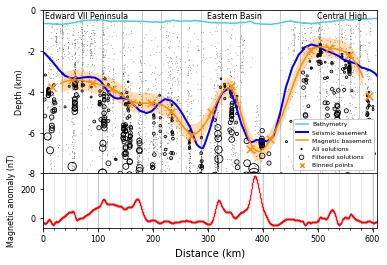

In [8]:
# initialize the figure
fig = plt.figure()
gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
ax0 = fig.add_subplot(gs[0])

#vertical lines of bin size
ax0.vlines(oib_filt_with_centers.Distance_36k.unique(),ymin=-10000, ymax=0, color='k', linewidth=1).set_alpha(.2)    

# bedmap2 bathymetry
ax0.plot(oib.Distance, oib.bedmap2_bed, 
         c='mediumturquoise', linewidth=1.5, label='Bathymetry')

# ANTOSTRAT basement  
ax0.plot(oib.Distance,oib.ANTOSTRAT_basement,  
         c='blue', linewidth=2, label='Seismic basement')

# interpolated OIB basement
ax0.plot(df_oib_basement.Distance, df_oib_basement.filt_clip, 
         c='darkorange', 
         label='Magnetic basement')

# uncertainty bounds
error=480
ax0.fill_between(df_oib_basement.Distance, 
                 df_oib_basement.filt_clip-error, 
                 df_oib_basement.filt_clip+error,
                 facecolor='darkorange', alpha=.3)
       
# OIB Werner dike solutions
ax0.scatter(oib.Distance, oib.Depth, 
            s = 1.5, marker='.', edgecolor='none', facecolor='k', 
            label='All solutions')

# OIB filtered solutions, scaled by Susc
ax0.scatter(oib_filt.Distance, oib_filt.Depth, 
            s = oib_filt.Susc*3, marker='o', edgecolors='k', facecolors='none', 
            linewidth=.8, label='Filtered solutions')

# binned OIB basement solutions
ax0.scatter(oib_bin_centers.Distance, oib_bin_centers.Depth_36k, 
            marker='x', c='darkorange', s=60, zorder=15, 
            label='Binned points')


# OIB magnetics    
ax1 = fig.add_subplot(gs[1], sharex=ax0)

ax1.scatter(oib_mag.Distance, oib_mag.Mag_anom_draped_1000, 
            s=.05, c='r', label='ROSETTA')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")   

#### SET TICKS / LIMITS    
ax1.set_xlim(oib.Distance.min(), oib.Distance.max()) 
ax1.set_xticks(np.arange(oib.Distance.min(), oib.Distance.max(), 100000))
ax1.set_xticklabels(np.arange(0, int((oib.Distance.max())/1000), 100))
ax1.set_xticks(np.arange(0, int((oib.Distance.max())), 20000), minor=True)
ax1.tick_params(axis='both', labelsize=8)
ax0.tick_params(axis='both', labelsize=8)

ax0.set_ylim(-8000, 0)
ax0.set_yticks((-8000, -6000, -4000, -2000, 0))
ax0.set_yticklabels((-8, -6, -4, -2, 0))

ax1.set_axisbelow(True)
ax1.grid(axis='x', which='major', alpha=0.8)
ax1.grid(axis='x', which='minor', alpha=0.3)
ax0.set_ylabel('Depth (km)', size=8)
ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
ax1.set_xlabel('Distance (km)')
lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
lgnd.legendHandles[-3]._sizes = [20]
lgnd.legendHandles[-2]._sizes = [20]
lgnd.legendHandles[-1]._sizes = [20]

ax0.text(x=5000, y=-400, s='Edward VII Peninsula', fontsize=8)
ax0.text(x=300000, y=-400, s='Eastern Basin', fontsize=8)
ax0.text(x=500000, y=-400, s='Central High', fontsize=8)

fig.subplots_adjust(hspace=0)
plt.setp(ax0.get_xticklabels(),visible=False)

# fig.show()

In [ ]:
out='outputs/Fig2_OIB_403_1.jpg'
fig.savefig(out, dpi=200)

# from OIB_werner_solutions_lines.ipynb
oib_all_points = pd.read_csv('OIB_Werner_all_points.csv',header=0,index_col=None,sep=',')
oib_binned_points = pd.read_csv('OIB_Werner_binned_points.csv',header=0,index_col=None,sep=',')

oib_403_1_all_points=oib_all_points[oib_all_points.Line==403.1]
oib_403_1_binned_points=oib_binned_points[oib_binned_points.Line==403.1]

bedmachine=oib_403_1_all_points[["x","y",'Distance']]
# bedmachine=pygmt.grdtrack(points=bedmachine, grid="BedMachine_surface_5k_wgs.nc", newcolname='surface')
# bedmachine=pygmt.grdtrack(points=bedmachine, grid="BedMachine_icebase_5k_wgs.nc", newcolname='icebase')
bedmachine=pygmt.grdtrack(points=bedmachine, grid="tmp/bedmachine_bed_wgs.nc", newcolname='bed')
bedmachine

fig = plt.figure()
gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
ax0 = fig.add_subplot(gs[0])

#### vertical lines of bin size
ax0.vlines(oib_403_1_all_points.Distance_36k.unique(),ymin=-10000, ymax=0, color='k', linewidth=1).set_alpha(.2)    

#### Bedmachine data
# ax0.plot(bedmachine.Distance, bedmachine.bed, c='mediumturquoise', linewidth=1.5, label='Bathymetry')
#### BEDMAP2 BED
ax0.plot(oib_403_1_all_points.Distance, oib_403_1_all_points.bedmap2_bed, 
         c='mediumturquoise', linewidth=1.5, label='Bathymetry')
#### ANTOSTRAT BASEMENT
ax0.plot(oib_403_1_all_points.Distance,oib_403_1_all_points.ANTOSTRAT_basement,  
         c='blue', linewidth=2, label='Seismic basement')

#### ROSETTA FILTERED DIKES 
#scaled by Susc
ax0.scatter(oib_403_1_all_points.Distance, oib_403_1_all_points.Depth_sl_filtered, 
            s = oib_403_1_all_points.Susc*3, marker='o', edgecolors='k', facecolors='none', 
            linewidth=.8, label='Scaled solutions')
ax0.scatter(oib_403_1_all_points.Distance, oib_403_1_all_points.Depth_Dikes, 
            s = 1.5, marker='.', edgecolor='none', facecolor='k', 
            label='All solutions')
#### ROSETTA SMOOTHED LINE
############################################
############################################ 
ax0.scatter(oib_403_1_binned_points.Distance, oib_403_1_binned_points.Depth_sl_36k, 
            marker='x', c='darkorange', s=60, zorder=15, 
            label='Binned points')

#Use if comparing lines
#ax0.plot(df5.Distance[df5.filt.notna()], df5.filt[df5.filt.notna()], c='darkorange', label='Magnetic basement')
ax0.plot(oib_403_1_all_points.Distance[oib_403_1_all_points.filt.notna()], 
         oib_403_1_all_points.filt[oib_403_1_all_points.filt.notna()], 
         c='darkorange', 
         label='Magnetic basement')
error=480
ax0.fill_between(oib_403_1_all_points.Distance[oib_403_1_all_points.filt.notna()], 
                 oib_403_1_all_points.filt[oib_403_1_all_points.filt.notna()]-error, 
                 oib_403_1_all_points.filt[oib_403_1_all_points.filt.notna()]+error,
                 facecolor='darkorange', alpha=.3)
############################################
############################################        
#### ROSETTA MAG    
ax1 = fig.add_subplot(gs[1], sharex=ax0)

ax1.scatter(oib_403_1_all_points.Distance, oib_403_1_all_points.Mag_anom_draped_1000, 
            s=.05, c='r', 
            label='ROSETTA')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")   
#### SET TICKS / LIMITS    
ax1.set_xlim(oib_403_1_all_points.Distance.min(), oib_403_1_all_points.Distance.max()) 
ax1.set_xticks(np.arange(oib_403_1_all_points.Distance.min(), oib_403_1_all_points.Distance.max(), 100000))
ax1.set_xticklabels(np.arange(0, int((oib_403_1_all_points.Distance.max())/1000), 100))
ax1.set_xticks(np.arange(0, int((oib_403_1_all_points.Distance.max())), 20000), minor=True)
ax1.tick_params(axis='both', labelsize=8)
ax0.tick_params(axis='both', labelsize=8)

ax0.set_ylim(-8000, 0)
ax0.set_yticks((-8000, -6000, -4000, -2000, 0))
ax0.set_yticklabels((-8, -6, -4, -2, 0))

ax1.set_axisbelow(True)
ax1.grid(axis='x', which='major', alpha=0.8)
ax1.grid(axis='x', which='minor', alpha=0.3)
ax0.set_ylabel('Depth (km)', size=8)
ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
ax1.set_xlabel('Distance (km)')
lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
lgnd.legendHandles[-3]._sizes = [20]
lgnd.legendHandles[-2]._sizes = [20]
lgnd.legendHandles[-1]._sizes = [20]

ax0.text(x=5000, y=-400, s='Edward VII Peninsula', fontsize=8)
ax0.text(x=300000, y=-400, s='Eastern Basin', fontsize=8)
ax0.text(x=500000, y=-400, s='Central High', fontsize=8)

fig.subplots_adjust(hspace=0)
plt.setp(ax0.get_xticklabels(),visible=False)

plt.show()

out='..\..\Manuscripts\GRL_Mag_Basement_2020\Fig2_OIB_403_1_200dpi.jpg'
fig.savefig(out, dpi=200)

oib_403_1_all_points.describe()

oib_403_3_all_points=oib_all_points[oib_all_points.Line==403.3]
oib_403_3_all_points.describe()

### 1) import Werner deconvolution solutions from Geosoft Oasis Montaj

# import geosoft .csv with Werner solutions for OIB line 403, 404, and ROSETTA lines
file_in = 'data\input\RIS123_1Hz_intermediate_Werner_2021_500_to_50k.csv'
df0 = pd.read_csv(file_in, header=0,index_col=None,sep=',')

# put line numbers into float format (L200 -> 200)
if type(df0.Line[0]) == str:
    df0.Line = df0.Line.str[1:]
df0['Line'] = pd.to_numeric(df0['Line']) 

# make dike solution depths be relative to sea level
# was relative to upwards continued flight elevation (1000masl)
df0['Depth'] = df0.Z_Dikes+1000

# if solutions are shallower then bathymetry, set equal to bathymetry
df0.Depth = np.where(df0.Depth>df0.bedmap2_bed, df0.bedmap2_bed, df0.Depth)  

# copy df to retain magnetics data to use in plotting
df_mag=copy.deepcopy(df0)

# drop columns and NaNs for oib dataset
df0_oib=df0.drop(df0.columns.difference(['Line','Distance','x','y','ANTOSTRAT_basement',
                                         'bedmap2_bed','Susc','Window_Width','Depth']), axis=1)
df0_oib.dropna(how='any', subset=('Line','Distance','x','y','Susc','Window_Width','Depth'), inplace=True)

# drop columns and NaNs for rosetta dataset
df0_rs=df0.drop(df0.columns.difference(['Line','Distance','x','y','bedmap2_bed', 
                                        'Susc','Window_Width','Depth']), axis=1)
df0_rs.dropna(how='any', subset=('Line','Distance','x','y','Susc','Window_Width','Depth'), inplace=True)

print(df0_oib.head())

### 2) define function to turn solutions into continuous 2D basement depth
* filter solutions based on their magnetic susceptibilty (parameter S) and Werner window width (paremeter W)
* horizontally bin the points, removing bins with less than specified minumum amount of filtered solutions (parameter C)
* interpolate line between these points
* compare depths for this line with ANTOSTRAT basement to get a mean misfit

# make function for filtering Werner solutions on susceptibilty & window width, and bins results
def filt_and_binning_oib(Line_oib, oib_parameter_s, oib_parameter_w, oib_parameter_b, oib_parameter_c):
    global mean_misfit, median_misfit, oib_filt_with_centers, oib, oib_mag, Distance_name, Depth_name, oib_filt, oib_bin_centers, df_oib_basement, oib_filt_with_centers
    
    # isolate an individual line
    oib = df0_oib[df0_oib.Line==Line_oib].copy()
    oib_mag = df_mag[df_mag.Line==Line_oib]

    # make sure ANTOSTRAT column is filled
    if Line_oib in [403.1, 403.3]:
        oib.ANTOSTRAT_basement.interpolate(method='linear', axis=0, inplace=True, limit_area='inside')
    else:
        pass
    
    # retain oib dataframe before filtering is applied
    oib_filt=copy.deepcopy(oib)

    """
    filter solutions based on susceptibility and window width
    add filtered solutions depths and distances to new columns
    i.e. Distance_36k and Depth_36k for iterations where b=36km
    """
    Distance_name = 'Distance_'+(str(int(oib_parameter_b/1000))+'k')
    Depth_name ='Depth_'+(str(int(oib_parameter_b/1000))+'k')
    oib_filt = pd.concat([oib_filt,pd.DataFrame(columns=[Distance_name, Depth_name])]) # add above columns to oib
    oib_filt[Distance_name] = np.floor(oib_filt.Distance[(oib_filt.Susc > oib_parameter_s) & 
                                                         (oib_filt.Window_Width < oib_parameter_w)]/oib_parameter_b)*oib_parameter_b 
    oib_filt[Depth_name] = oib_filt.Depth[(oib_filt.Susc > oib_parameter_s) & (oib_filt.Window_Width < oib_parameter_w)]
    if Line_oib in [403.1, 403.3]:
        oib_filt.dropna(inplace=True) # remove rows with NaNs
    else: 
        cols=oib_filt.loc[:, ~oib_filt.columns.isin(['ANTOSTRAT_basement'])].columns # all cols except ANTOSTRAT
        oib_filt.dropna(subset=cols, inplace=True) # remove rows with NaNs except for ANTOSTAT columns, since its all nans 

    # Set bin centers equal to 95% depth of solutions within bin
    def quant(x):
        return x.quantile(0.95)
    # new df with only binned points, with distances set to the center of the bins and depths set to 95% of all points within bins
    oib_bin_centers = oib_filt.groupby([Distance_name], as_index=False).agg({Depth_name: quant})
    oib_bin_centers['Distance'] = oib_bin_centers[Distance_name]+(oib_parameter_b/2)
    oib_bin_centers['binned']=1 # keep track of binned points

    # rename Depth_name column so oib_bin_centers can be merged
    oib_filt.rename(columns={Depth_name:'Depth_filtered'}, inplace=True)

    # add the binned solutions to oib_filt
    oib_filt_with_centers = oib_filt.set_index(['Distance', Distance_name]).join(oib_bin_centers.set_index(['Distance', Distance_name]), how='outer')
    oib_filt_with_centers.reset_index(inplace=True)
    oib_filt_with_centers.sort_values(['Distance'], inplace=True)
    #fill nan's in columns, except 'binned'
    for col in oib_filt_with_centers.columns:
        if col == 'binned':
            pass
        else:
            oib_filt_with_centers[col].interpolate(method='linear', limit_direction='both', inplace=True)    

    """
    retain only the bins which contain a minumum number (count) of points
    """
    # number of filtered points within each bin
    oib_filt_with_centers['counts'] = oib_filt_with_centers.groupby([Distance_name])['Depth_filtered'].transform('count')
    oib_bin_centers=oib_filt_with_centers[oib_filt_with_centers.binned.notna()]
    oib_bin_centers=oib_bin_centers[oib_bin_centers.counts>oib_parameter_c]
    
    """
    Compare OIB basement results with ANTOSTRAT basement results
    """
    try:
        # interpolate line between binned points for comparison with ANTOSTRAT
        x1 = min(oib_bin_centers.Distance)
        x2 = max(oib_bin_centers.Distance)
        increment = 5000  #sample every 5k for optimization, every 1km of uncertainty analysis
        Distance_new = np.arange(x1, x2, increment)  # creates array for distance to interpolate onto, 1 point every 5km
        window = int(30000/increment) # window size for filtering resulting interpolated line
        try:
            # define function which takes distance, and gives interpolated depths
            f = scipy.interpolate.interp1d(oib_bin_centers.Distance, oib_bin_centers[Depth_name], kind='quadratic', fill_value='extrapolate') 
            # apply function to new distance array
            oib_basement=f(Distance_new)  
            # add new distances and interpolated depth to dataframe
            oib_solutions=pd.DataFrame(data={'Distance':Distance_new, 'oib_basement':oib_basement})
            # smooth the interpolated depths with a rolling mean window 
            oib_solutions['oib_basement_filt'] = oib_solutions.oib_basement.rolling(window, center=True).mean()
            oib_solutions.sort_values(['Distance'], inplace=True)
            # add 'oib_basement' and 'oib_basement_filt' columns to database to get x, y, etc. 
            df_oib_basement=oib_filt_with_centers.set_index('Distance').join(oib_solutions.set_index('Distance'), how='outer')
            df_oib_basement.reset_index(inplace=True)
            df_oib_basement.sort_values(['Distance'], inplace=True)
            # fill nans in all columns except 'oib_basement_filt' to get x, y, etc. for interpolated basement line
            for col in df_oib_basement.columns:
                if col == 'oib_basement_filt':
                    pass
                else:
                    df_oib_basement[col].interpolate(method='linear', limit_area='inside', inplace=True)    
            # drop all rows except for interpolate basement line
            # df_oib_basement.dropna(inplace=True)
            df_oib_basement.dropna(subset=['oib_basement_filt'], inplace=True)
            # if solutions are shallower then bathymetry, set equal to bathymetry
            df_oib_basement['filt_clip'] = np.where(df_oib_basement.oib_basement_filt>df_oib_basement.bedmap2_bed,
                                                        df_oib_basement.bedmap2_bed, df_oib_basement.oib_basement_filt)
            """
            if OIB line 403, compare resulting interpolated line with coincident ANTOSTRAT basement 
            """
            if Line_oib in [403.1, 403.3]:
                df_oib_basement['misfit'] = df_oib_basement.ANTOSTRAT_basement - df_oib_basement.filt_clip 
                df_oib_basement['abs_misfit'] = np.abs(df_oib_basement.misfit)
                mean_misfit=df_oib_basement.abs_misfit.mean()
                median_misfit=df_oib_basement.abs_misfit.median()
            else:
                mean_misfit=np.nan
                median_misfit=np.nan
        except: 
            mean_misfit=np.nan
            median_misfit=np.nan
            df_oib_basement=[]  
        # if more than 2 solution per 100km than continue  
        if (len(oib_bin_centers))/((max(oib_filt_with_centers.Distance)-min(oib_filt_with_centers.Distance))/100_000)<2: 
            mean_misfit=np.nan 
            median_misfit=np.nan
        else: 
            pass
    except: 
        mean_misfit=np.nan
        median_misfit=np.nan
        df_oib_basement=[]  
    return mean_misfit

### 3) define function to plot the above results

"""
erase any leftover global variables from above function
"""
vars=('vars','mean_misfit','median_misfit','oib_filt_with_centers','oib','oib_mag','Distance_name',
      'Depth_name','oib_filt','oib_bin_centers','df_oib_basement',)
save_list = globals() # list of all variables
save_list = [k for k in save_list if k not in vars]# all variables except thos in vars
# #finally, clear all variables (except default and saved) with:
for name in dir():
    if name not in save_list:
        del globals()[name]
"""
matplotlib plotting function
"""
def plot_OIB(Line_oib, oib_parameter_s, oib_parameter_w, oib_parameter_b, oib_parameter_c, animation=False): 
    global fig
    # run above function with parameters
    filt_and_binning_oib(Line_oib, oib_parameter_s, oib_parameter_w, oib_parameter_b, oib_parameter_c)

    # initialize figure
    if animation==True:
        pass
    else:
        fig = plt.figure(facecolor='w')
    
    gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
    ax0 = fig.add_subplot(gs[0])
    # vertical lines of bin size
    ax0.vlines(oib_filt_with_centers[Distance_name].unique(),ymin=-10000, ymax=0, 
               color='k', linewidth=1).set_alpha(.2)    
    
    # bedmap2 bathymetry
    ax0.plot(oib.Distance, oib.bedmap2_bed, c='mediumturquoise', 
             linewidth=1.5, label='Bathymetry')
    
    # OIB filtered solutions, scaled by Susc
    ax0.scatter(oib_filt.Distance, oib_filt.Depth, s = oib_filt.Susc*3, marker='o', 
                edgecolors='k', facecolors='none', linewidth=.8, label='Filtered solutions')
    
    # OIB Werner dike solutions 
    ax0.scatter(oib.Distance, oib.Depth, s = 1.5, marker='.', edgecolor='none', 
                facecolor='k', label='All solution')
    
    # ANTOSTRAT basement  
    if Line_oib in [403.1, 403.3]:
        ax0.plot(oib.Distance, oib.ANTOSTRAT_basement,  c='blue', 
                 linewidth=2, label='Seismic Basement')
    else:
        pass
    
    # interpolated OIB basement
    try:
        ax0.plot(df_oib_basement.Distance, df_oib_basement.filt_clip, 
         c='darkorange', label='Mag basement')   
    except:
        pass
    
    # binned OIB basement solutions
    ax0.scatter(oib_bin_centers.Distance, oib_bin_centers[Depth_name], marker='x', 
                c='orange', s=60, label='Binned solutions', zorder=15)
    
    # OIB magnetics  
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax1.scatter(oib_mag.Distance, oib_mag.Mag_anom_draped_1000, s=.05, 
                c='r', label='ROSETTA')
    ax1.yaxis.tick_left()
    ax1.yaxis.set_label_position("left")
        
    # reverse x axis is flight is West to East
    if oib.Distance[oib.x.idxmin()] > oib.Distance[oib.x.idxmax()]:
        ax1.set_xlim(oib.Distance.max(), oib.Distance.min()) 
    else:
        ax1.set_xlim(oib.Distance.min(), oib.Distance.max())
        ax1.set_xticks(np.arange(oib.Distance.min(), oib.Distance.max(), 100000))
        ax1.set_xticklabels(np.arange(0, int((oib.Distance.max())/1000), 100))
        ax1.set_xticks(np.arange(0, int((oib.Distance.max())), 20000), minor=True)
    
    # set figure parameters
    ax1.tick_params(axis='both', labelsize=8)
    ax0.tick_params(axis='both', labelsize=8)
    ax0.set_ylim(-8000, 0)
    ax0.set_yticks((-8000, -6000, -4000, -2000, 0))
    ax0.set_yticklabels((-8, -6, -4, -2, 0))
    ax1.grid(axis='x', which='major', alpha=0.8)
    ax1.grid(axis='x', which='minor', alpha=0.3)
    ax0.set_ylabel('Depth (km)', size=8)
    ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
    ax1.set_xlabel('Distance (km)')
    lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
    lgnd.legendHandles[-1]._sizes = [20]
    lgnd.legendHandles[-2]._sizes = [20]
    lgnd.legendHandles[-3]._sizes = [20]
    lgnd.legendHandles[-4]._sizes = [20]
    try:
        lgnd.legendHandles[-5]._sizes = [20]
    except:
        pass
    txt = '''parameter s > {} 
            parameter b = {} km
             parameter c > {} solutions
            parameter w < {} km
            '''.format(oib_parameter_s, oib_parameter_b/1000, oib_parameter_c, oib_parameter_w/1000) 
    plt.figtext(.5,0.02, txt, ha='center', va='top', fontsize=8)
    try:
        plt.figtext(.8,0.01, "Misfit: {} m".format(int(mean_misfit)), ha='center', va='top', fontsize=8)
    except:
        pass
    plt.figtext(.5,.91, 'OIB line {}'.format(oib.Line.iloc[0]), ha='center', va='top', fontsize=10)
    fig.subplots_adjust(hspace=0)
    plt.setp(ax0.get_xticklabels(),visible=False)
    # plt.close()
    # plt.show()
    # return fig

import matplotlib.animation as animation
from IPython.display import HTML

Line_oib=403.1
# Line_oib=403.3,
oib_parameter_s=1
oib_parameter_w=10000
oib_parameter_b=36000
oib_parameter_c=6

filt_and_binning_oib(Line_oib=Line_oib,
    oib_parameter_s=oib_parameter_s,
    oib_parameter_w=oib_parameter_w,
    oib_parameter_b=oib_parameter_b,
    oib_parameter_c=oib_parameter_c)


fig = plt.figure(facecolor='w', dpi=400)
gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)

# OIB magnetics  
ax1.scatter(oib_mag.Distance, oib_mag.Mag_anom_draped_1000, s=.05, c='r')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")

# reverse x axis is flight is West to East
if oib.Distance[oib.x.idxmin()] > oib.Distance[oib.x.idxmax()]:
    ax1.set_xlim(oib.Distance.max(), oib.Distance.min()) 
else:
    ax1.set_xlim(oib.Distance.min(), oib.Distance.max())
    ax1.set_xticks(np.arange(oib.Distance.min(), oib.Distance.max(), 100000))
    ax1.set_xticklabels(np.arange(0, int((oib.Distance.max())/1000), 100))
    ax1.set_xticks(np.arange(0, int((oib.Distance.max())), 20000), minor=True)

# set figure parameters
ax1.tick_params(axis='both', labelsize=8)
ax0.tick_params(axis='both', labelsize=8)
ax0.set_ylim(-8000, 0)
ax0.set_yticks((-8000, -6000, -4000, -2000, 0))
ax0.set_yticklabels((-8, -6, -4, -2, 0))
ax1.grid(axis='x', which='major', alpha=0.8)
ax1.grid(axis='x', which='minor', alpha=0.3)
ax0.set_ylabel('Depth (km)', size=8)
ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
ax1.set_xlabel('Distance (km)')

plt.figtext(.5,.91, 'OIB line {}'.format(oib.Line.iloc[0]), ha='center', va='top', fontsize=10)
fig.subplots_adjust(hspace=0)
plt.setp(ax0.get_xticklabels(),visible=False)

# bedmap2 bathymetry
ax0.plot(oib.Distance, oib.bedmap2_bed, c='mediumturquoise', linewidth=1.5, label='Bathymetry')
ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)

ims=[]
ims.append([])

# ANTOSTRAT basement  
anto,=ax0.plot(oib.Distance, oib.ANTOSTRAT_basement,  c='blue', linewidth=2, label='Seismic Basement')  
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, lgnd])

# OIB Werner dike solutions, scaled
sols_s=ax0.scatter(oib.Distance, oib.Depth, s = oib.Susc*3, marker='o', edgecolors='k', facecolors='none', linewidth=.8)

# OIB Werner dike solutions, dots
sols=ax0.scatter(oib.Distance, oib.Depth, s = 1.5, marker='.', edgecolor='none', facecolor='k', label='All solution')
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, lgnd, sols_s, sols])

# OIB filtered solutions, scaled by Susc
filt_sols=ax0.scatter(oib_filt.Distance, oib_filt.Depth, s = oib_filt.Susc*3, marker='o', edgecolors='k', facecolors='none', linewidth=.8, label='Filtered solutions')    
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, sols, filt_sols, lgnd])

# vertical lines of bin size
lines=ax0.vlines(oib_filt_with_centers[Distance_name].unique(),ymin=-10000, ymax=0, color='k', linewidth=1, alpha=.2)
ims.append([anto, sols, filt_sols, lines, lgnd])

# bins
bins=ax0.scatter(oib_filt_with_centers[oib_filt_with_centers.binned.notna()].Distance, oib_filt_with_centers[oib_filt_with_centers.binned.notna()][Depth_name], marker='x', c='orange', s=60)
ims.append([anto, sols, filt_sols, lines, bins, lgnd])

# bin > counts
binned=ax0.scatter(oib_bin_centers.Distance, oib_bin_centers[Depth_name], marker='x', c='orange', s=60, label='Binned solutions')
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, sols, filt_sols, lines, binned, lgnd])

# interpolated OIB basement
base,=ax0.plot(df_oib_basement.Distance, df_oib_basement.filt_clip, c='darkorange', label='Mag basement')
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, sols, filt_sols, lines, binned, base, lgnd])
plt.close()
anim = animation.ArtistAnimation(fig, ims, interval=800, blit=False)
HTML(anim.to_jshtml())
# anim.save('OIB_ANTOSTRAT_tie.gif')

## Filtering / binning process visualized; frame by frame
Frame 1: Bathymetry in light blue, with OIB magnetics data in red  
Frame 2: ANTOSTAT seismic basement in dark blue  
Frame 3: All Werner dike solutions, scaled by parameter S (magnetic susceptibilty\*dike width)  
Frame 4: Shallow solutions removed based on parameter W & S, remaining solutions scaled  
Frame 5: Vertical bin lines added  
Frame 6: Crosses added to centers of each bin, and 95% bin depth  
Frame 7: Bins with < low numbers of solutions removed (parameter C)  
Frame 8: Bins interpolated to produce line, representing basement surface

<!-- ![SegmentLocal](OIB_ANTOSTRAT_tie.gif "segment") -->


### 4) pick parameter values and plot the results

# choose line, and pick parameter values
plot_OIB(
    Line_oib=403.1,
    # Line_oib=403.3,
    oib_parameter_s=.1,
    oib_parameter_w=20000,
    oib_parameter_b=36000,
    oib_parameter_c=2, animation=False)

## 5) optimize parameters to match OIB to ANTOSTRAT basement

The above function *filt_and_binning_oib* takes an input of parameters w,s,b, and c, and returns a mean misfit between OIB and ANTOSTRAT basement. We now apply a wide range of these parameter values to this function to find which values result in the smallest misfit. First we set up an empty dataframe for all possible combinations of 21 values for each variable, then for each combination we apply *filt_and_binning_oib* and save the resulting misfit value. We do this for both line 403.1 and 403.3.

### Create optimization database
This will contain a column for each parameter. Each parameter will have 21 values, and the rows will be each unique combination of these parameter values. This results in a total of 194481 combinations.

s=np.linspace(0, 4, 21)
w=np.linspace(0, 40000, 21, dtype=int)
b=np.linspace(0, 40000, 21, dtype=int)
c=np.linspace(0, 40, 21, dtype=int)
params=[s,w,b,c]         
comb=list(itertools.product(*params))   
df_misfit_oib=pd.DataFrame(comb, columns=['susc', 'window', 'bin', 'count'])

### Calculate misfit for each row
Apply the function *filt_and_binning_oib* to each row and save the results. Do this for both lines; 403.1 and 403.3.  
WARNING, THIS MAY TAKE SEVERAL HOURS TO RUN!

from tqdm import tqdm
tqdm.pandas()
lines=[403.1, 403.3]
for l in lines:# look into replacing apply with vectorization
    df_misfit_oib['misfit_{}'.format(l)]=df_misfit_oib.progress_apply(lambda x: filt_and_binning_oib(Line_oib=l,  
                                oib_parameter_s=x['susc'], 
                                oib_parameter_w=x['window'], 
                                oib_parameter_b=x['bin'], 
                                oib_parameter_c=x['count']), axis=1)
df_misfit_oib.describe()

### Organize output data
For each row, take the average of the misfits for both 403.1 and 403.3.   
Sort by these average values and save as a csv.  
Drop erroneous first 4 rows. 

# average the misfit of lines 403.1 and 403.3.
df_misfit_oib['misfit_oib_avg']=df_misfit_oib[['misfit_403.1', 'misfit_403.3']].dropna(subset=['misfit_403.1', 'misfit_403.3']).mean(axis=1)
# sort from lowest misfit to highest.
df_misfit_oib.sort_values('misfit_oib_avg', inplace=True)
# save as csv
df_misfit_oib.to_csv('data/results/mean_misfit_oib_optimize.csv', index=False)

# load file
df_mean_misfit_oib= pd.read_csv('data/results/mean_misfit_oib_optimize.csv', header=0, index_col=None, sep=',')
# drop first 4 rows; issues with too short of interpolated lines
df_mean_misfit_oib_clip=df_mean_misfit_oib[5::]
# reset index
df_mean_misfit_oib_clip.reset_index(inplace=True, drop=True)
df_mean_misfit_oib_clip.head()

### Optimization results

Above are the top 5 sets of parameters which produced the best match between OIB to ANTOSTRAT basement models. We use the values in row 0 as our final optimized parameters.
These values include:
* parameter W: 10 km (maximum Werner window width)
* parameter S: 1.0 (minimum magnetic susceptibility x body width) 
* parameter B: 36 km (bin width)
* parameter C: 6 (minumum count of solutions / bin)

Using these parameters, we plot the resulting OIB basement solutions below, including for OIB line 404, over the Ross Ice Shelf

for line in (403.1, 403.3, 404.59, 404.65):     
        row = 0
        plot_OIB(Line_oib = line, 
                oib_parameter_s=df_mean_misfit_oib_clip['susc'].iloc[row], 
                oib_parameter_w=df_mean_misfit_oib_clip["window"].iloc[row], 
                oib_parameter_b=df_mean_misfit_oib_clip['bin'].iloc[row], 
                oib_parameter_c=df_mean_misfit_oib_clip['count'].iloc[row])

## Visualize optimization results
To visualize the optimization process, we will make animations for a random selection of parameter sets.

# sample the optimization database, getting 20 random rows
df_sample=df_mean_misfit_oib_clip[df_mean_misfit_oib_clip.misfit_oib_avg.notna()].sample(n=20)

s=np.array(df_sample['susc'])  
w=np.array(df_sample["window"])
b=np.array(df_sample['bin'])
c=np.array(df_sample['count'])

fig = plt.figure(facecolor='w', dpi=400)

def animate(i):
    plot_OIB(
        Line_oib=403.1,
        oib_parameter_s=s[i],
        oib_parameter_w=w[i],
        oib_parameter_b=b[i],
        oib_parameter_c=c[i], animation=True)
plt.close()
anim = matplotlib.animation.FuncAnimation(fig, animate, blit=False, frames=len(s), interval=400)
HTML(anim.to_jshtml())